In [41]:
import os
import wbgapi as wb
import pandas as pd
import requests
import xml.etree.ElementTree as ET

In [42]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import ydata_profiling

In [43]:
# Carga de índices y lista de paises
# Ruta completa del archivo Excel
ruta_lista_ods = r"C:\Users\Usuario\Downloads\CEPAL\Sustainable_Development_Goals(4).xlsx"
ruta_lista_devg = r"C:\Users\Usuario\Downloads\CEPAL\Codigos_Indicadores_Desarrollo(3).xlsx"

# Carga el archivo Excel en un DataFrame de pandas
df_ods = pd.read_excel(ruta_lista_ods)
df_devg = pd.read_excel(ruta_lista_devg)

# Ahora 'df' contiene los datos del archivo Excel
list_ods_id = df_ods["Series Code"].dropna().tolist()
list_devg_id = df_devg["Series Code"].dropna().tolist()

# Valores a eliminar
valores_a_eliminar = ["SL.ISV.IFRM.ZS", "SL.ISV.IFRM.FE.ZS", "SL.ISV.IFRM.MA.ZS"]

# Crea una nueva lista excluyendo los valores a eliminar
list_ods_id = [valor for valor in list_ods_id if valor not in valores_a_eliminar]

# Lista de países
countries = ["ARG", "BHS", "BRB", "BOL", "BRA", "CAN", "COL", "CRI", "CUB", "CHL", "ECU", "SLV", "USA", "FRA", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "NLD", "PAN", "PRY", "PER", "GBR", "DOM", "SUR", "TTO", "URY", "VEN"]

#len(list_ods_id)

In [44]:
###########Carga o descarga de dataset de objetivos de desarrollo sostenible mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_ods = r"C:\Users\Usuario\Downloads\CEPAL\ods_raw.xlsx"

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_ods):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    ods_raw_df = pd.read_excel(ruta_guardado_ods)
else:
    # Si el archivo no existe, realiza la conexión a la base de datos de wb y crea el diccionario de DataFrames
    dfs_ods = {}

    # Ciclo para crear dataframes para cada indicador
    for series_code in list_ods_id:
        # Crea un dataframe para el indicador actual
        df = wb.data.DataFrame(
            series_code,
            countries,
            index="time",
            numericTimeKeys=True,
            labels=True
        )

        # Genera un nombre en la notación "id_ODS"
        dataframe_name = f"{series_code}_ODS"

        # Agrega el DataFrame al diccionario usando el nombre generado como clave
        dfs_ods[dataframe_name] = df

    # Inicializa una lista para almacenar los DataFrames concatenados
    concat_ods_dfs = []

    # Recorre el diccionario dfs_ods
    for dataframe_name, df in dfs_ods.items():
        # Agrega una columna 'series_code' con el valor correspondiente
        df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
        # Agrega el DataFrame actual a la lista
        concat_ods_dfs.append(df)

    # Concatena todos los DataFrames en uno solo
    ods_raw_df = pd.concat(concat_ods_dfs, ignore_index=True)

    # Mueve la columna 'series_code' al primer lugar
    ods_raw_df.insert(0, 'series_code', ods_raw_df.pop('series_code'))

    # Guarda el DataFrame como un archivo Excel en la ubicación especificada
    ods_raw_df.to_excel(ruta_guardado_ods, index=False)
    
    

###########Carga o descarga de dataset de objetivos de desarrollo global mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_devg = r"C:\Users\Usuario\Downloads\CEPAL\devg_raw.xlsx"

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_devg):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    devg_raw_df = pd.read_excel(ruta_guardado_devg)
else:
    # Diccionario para almacenar los DataFrames
    dfs_devg = {}

    # Ciclo para crear dataframes para cada indicador
    for series_code in list_devg_id:
        # Crea un dataframe para el indicador actual
        df = wb.data.DataFrame(
            series_code,
            countries,
            index="time",
            numericTimeKeys=True,
            labels=True
        )

        # Genera un nombre en la notación "id_ODS"
        dataframe_name = f"{series_code}_DEVG"

        # Agrega el DataFrame al diccionario usando el nombre generado como clave
        dfs_devg[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_devg_dfs = []

    # Recorre el diccionario dfs_ods
    for dataframe_name, df in dfs_devg.items():
        # Agrega una columna 'series_code' con el valor correspondiente
        df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
        # Agrega el DataFrame actual a la lista
        concat_devg_dfs.append(df)

    # Concatena todos los DataFrames en uno solo
    devg_raw_df = pd.concat(concat_devg_dfs, ignore_index=True)

    # Mueve la columna 'series_code' al primer lugar
    devg_raw_df.insert(0, 'series_code', devg_raw_df.pop('series_code'))

    # Guarda el DataFrame como un archivo Excel en la ubicación especificada
    devg_raw_df.to_excel(ruta_guardado_devg, index=False)
    
    
    
###########Carga o descarga de dataset de indicadores de corrupción mediante libreria API del banco mundial

# Ruta donde deseas guardar el archivo Excel
ruta_guardado_corr = r"C:\Users\Usuario\Downloads\CEPAL\corr_raw.xlsx"
  
#extraer lista de indicadores de corrupción
# URL del documento XML
url = "https://api.worldbank.org/v2/sources/3/indicators"

# Realiza una solicitud HTTP para obtener el contenido del enlace
response = requests.get(url)

# Verifica si la solicitud fue exitosa (código de respuesta 200)
if response.status_code == 200:
    # Parsea el contenido XML
    xml_content = response.content
    root = ET.fromstring(xml_content)

    # Inicializa una lista para almacenar los elementos 'indicator'
    list_corr_id = []

    # Itera a través de los elementos 'indicator' en el árbol XML
    for indicator in root.findall(".//wb:indicator", namespaces={"wb": "http://www.worldbank.org"}):
        # Obtiene el valor del atributo 'id' y el texto dentro del elemento 'wb:name'
        indicator_id = indicator.get("id")
        indicator_name = indicator.find("wb:name", namespaces={"wb": "http://www.worldbank.org"}).text

        # Almacena los datos en un diccionario
        indicator_data = {
            "id": indicator_id,
            "name": indicator_name
        }

        # Agrega el diccionario a la lista de indicadores
        list_corr_id.append(indicator_data)

# Código para obtener indicadores adicionales si es necesario
# ...

# Verifica si el archivo 'corr_raw.xlsx' existe en el directorio
if os.path.exists(ruta_guardado_corr):
    # Si el archivo existe, carga el DataFrame desde el archivo Excel
    corr_raw_df = pd.read_excel(ruta_guardado_corr)
else:

        dfs_corr = {}

        # Ciclo para crear dataframes para cada indicador
        for indicator_data in list_corr_id:
            indicator_id = indicator_data["id"]

            # Crea un dataframe para el indicador actual
            df = wb.data.DataFrame(
                indicator_id,
                countries,
                index="time",
                numericTimeKeys=True,
                labels=True
            )

            # Genera un nombre en la notación "id_cepal"
            dataframe_name = f"{indicator_id}_CORR"

            # Agrega el DataFrame al diccionario usando el nombre generado como clave
            dfs_corr[dataframe_name] = df

        # Inicializa una lista para almacenar los DataFrames concatenados
        concat_corr_dfs = []

        # Recorre el diccionario dfs_corr
        for dataframe_name, df in dfs_corr.items():
            # Agrega una columna 'series_code' con el valor correspondiente
            df['series_code'] = dataframe_name.split('_')[0]  # Obtiene el series_code a partir del nombre
            # Agrega el DataFrame actual a la lista
            concat_corr_dfs.append(df)

        # Concatena todos los DataFrames en uno solo
        corr_raw_df = pd.concat(concat_corr_dfs, ignore_index=True)

        # Mueve la columna 'series_code' al primer lugar
        corr_raw_df.insert(0, 'series_code', corr_raw_df.pop('series_code'))

        # Guarda el DataFrame como un archivo Excel en la ubicación especificada
        corr_raw_df.to_excel(ruta_guardado_corr, index=False)

In [45]:
# Lista para almacenar los nuevos DataFrames sin filas de NaN
clnd_dfs = []

raw_dfs = [ods_raw_df, devg_raw_df, corr_raw_df]

for df in raw_dfs:
    # Copia el DataFrame original para mantenerlo intacto
    nuevo_df = df.copy()
    
    # Guarda las filas eliminadas en otro DataFrame
    filas_eliminadas = nuevo_df[nuevo_df.iloc[:, 2:34].isnull().all(axis=1)]
    
    ## Elimina las filas con todos los valores NaN
    nuevo_df.dropna(subset=nuevo_df.columns[2:34], how='all', inplace=True)
    
    # Agrega el nuevo DataFrame a la lista de nuevos DataFrames
    clnd_dfs.append(nuevo_df)
    
#######paises
## Diccionario para almacenar los resultados
nan_info_dict = {}

# Itera a través de la lista de DataFrames sin filas de NaN (clnd_dfs)
for i, df in enumerate(clnd_dfs):
    # Calcula la cantidad de datos NaN por cada columna en el DataFrame
    nan_count_per_column = df.isna().sum()
    
    # Calcula el porcentaje de datos perdidos en cada columna
    total_rows = len(df)
    nan_percentage_per_column = (nan_count_per_column / total_rows) * 100
    
    # Almacena la información en un DataFrame
    nan_info_df = pd.DataFrame({
        "NaN_Count": nan_count_per_column,
        "NaN_Percentage": nan_percentage_per_column
    })
    
    # Ordena el DataFrame por la columna "NaN_Count" en orden descendente
    nan_info_df = nan_info_df.sort_values(by="NaN_Count", ascending=False)
    
    # Agrega el DataFrame con la información al diccionario
    nan_info_dict[f"clean_{i + 1}"] = nan_info_df

# Obtener el DataFrame correspondiente a clean_ods_df en nan_info_dict (por índice)
nan_info_clean_ods = list(nan_info_dict.values())[0]

#### Filtrar las columnas con porcentaje superior al 26.0
columns_to_exclude = nan_info_clean_ods[nan_info_clean_ods["NaN_Percentage"] > 26.0].index.tolist()

# Eliminar las columnas coincidentes de los dos primeros DataFrames en clnd_dfs
for i in range(2):
    clnd_dfs[i] = clnd_dfs[i].drop(columns=columns_to_exclude)

# Crear el nuevo DataFrame excluded_corr a partir de clnd_dfs[2]
excluded_corr = clnd_dfs[2][columns_to_exclude]

# Eliminar las columnas coincidentes de clnd_dfs[2]
clnd_dfs[2] = clnd_dfs[2].drop(columns=columns_to_exclude)

# Almacenar los DataFrames en sus variables originales (opcional)
clnd_dfs.append(excluded_corr)

##########indicadores

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "series_code"
    unique_series_codes = df["series_code"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_series = {}

    # Filtra el DataFrame por cada valor único en "series_code" y calcula el porcentaje de NaN
    for series_code in unique_series_codes:
        filtered_df = df[df["series_code"] == series_code]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_series[series_code] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_series

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs

# Crear listas de series_code que tengan un porcentaje superior a 26.0 en los tres primeros DataFrames de clnd_dfs
series_codes_to_exclude = set()

# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    for series_code, nan_percentage in nan_percentage_dict[f"clean_{i + 1}"].items():
        if nan_percentage > 26.0:
            series_codes_to_exclude.add(series_code)

# Filtrar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["series_code"].isin(series_codes_to_exclude)]

# Ahora clnd_dfs contiene los DataFrames sin las filas con series_code con porcentaje superior a 26.0 en los tres primeros DataFrames



#######años

# Diccionario para almacenar los porcentajes de NaN por DataFrame
nan_percentage_dict = {}

# Itera a través de la lista de DataFrames en clnd_dfs
for i, df in enumerate(clnd_dfs[:3]):
    # Obtiene los valores únicos en la columna "Year"
    unique_years = df["Time"].unique()

    # Diccionario para almacenar los porcentajes de NaN por DataFrame filtrado
    nan_percentage_per_year = {}

    # Filtra el DataFrame por cada valor único en "Year" y calcula el porcentaje de NaN
    for year in unique_years:
        filtered_df = df[df["Time"] == year]
        nan_percentage = (filtered_df.isna().sum().sum() / filtered_df.size) * 100
        nan_percentage_per_year[year] = nan_percentage

    # Almacena el diccionario de porcentajes de NaN en el diccionario principal
    nan_percentage_dict[f"clean_{i + 1}"] = nan_percentage_per_year

# Resultado: nan_percentage_dict contendrá los porcentajes de NaN para cada DataFrame filtrado en clnd_dfs


# Crear una lista para almacenar los años con porcentaje superior a 26.0
years_to_exclude = []

# Iterar a través del nan_percentage_dict
for i in range(3):
    nan_percentage_per_year = nan_percentage_dict[f"clean_{i + 1}"]
    for year, nan_percentage in nan_percentage_per_year.items():
        if nan_percentage > 26.0 and year not in years_to_exclude:
            years_to_exclude.append(year)

# Eliminar las filas correspondientes de los tres primeros DataFrames en clnd_dfs
for i in range(3):
    clnd_dfs[i] = clnd_dfs[i][~clnd_dfs[i]["Time"].isin(years_to_exclude)]
    
# Iterar a través de los primeros tres DataFrames en clnd_dfs
for i in range(3):
    df = clnd_dfs[i]  # Obtén el DataFrame actual
    unique_series_codes = df["series_code"].unique()  # Obtiene los valores únicos en "series_code"

    # Iterar a través de los valores únicos en "series_code"
    for series_code in unique_series_codes:
        # Filtra el DataFrame por el valor único en "series_code" y copia el resultado
        filtered_df = df[df["series_code"] == series_code].copy()
        
        # Calcula la mediana por columna en el subconjunto de datos y reemplaza NaN por la mediana
        median_values = filtered_df.median(numeric_only=True)  # Calcula la mediana por columna
        filtered_df.fillna(median_values, inplace=True)  # Reemplaza NaN por la mediana en el DataFrame copiado

        # Actualiza el DataFrame original con los valores reemplazados
        df.update(filtered_df)

# Ahora, clnd_dfs contiene los DataFrames originales con los valores NaN reemplazados por las medianas correspondientes en cada serie_code




In [46]:
clnd_dfs[0]

,series_code,Time,ARG,BOL,BRA,CAN,CHL,COL,CRI,DOM,...,FRA,GBR,HND,MEX,NLD,PAN,PER,PRY,URY,USA
1,FX.OWN.TOTL.ZS,2021,71.63000,68.89000,84.04000,99.63000,87.06000,59.72000,68.49000,51.30000,...,99.24000,99.76000,37.85000,36.93000,99.73000,44.97000,57.50000,54.42000,74.13000,94.95000
5,FX.OWN.TOTL.ZS,2017,48.71000,54.41000,70.04000,99.73000,74.35000,45.76000,67.84000,56.24000,...,94.00000,96.37000,45.34000,36.93000,99.64000,46.49000,42.60000,48.65000,63.87000,93.12000
8,FX.OWN.TOTL.ZS,2014,50.20000,41.80000,68.12000,99.10000,63.26000,39.00000,64.55000,54.09000,...,96.58000,98.93000,31.49000,39.14000,99.30000,43.66000,28.98000,48.65000,45.59000,93.58000
11,FX.OWN.TOTL.ZS,2011,33.13000,28.03000,55.86000,95.80000,42.18000,30.43000,50.36000,38.20000,...,96.98000,97.20000,20.51000,27.43000,98.66000,24.93000,20.46000,21.72000,23.54000,87.96000
64,FX.OWN.TOTL.FE.ZS,2021,73.75000,63.29000,80.87000,99.51000,86.62000,56.20000,61.08000,48.96000,...,100.00000,99.91000,28.85000,33.29000,99.47000,43.11000,53.03000,55.35000,75.73000,96.79000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,SL.EMP.WORK.ZS,1995,70.64411,29.79128,62.58083,84.33201,69.93645,51.22395,71.38242,58.31049,...,86.35035,86.52421,47.06759,58.47977,87.29871,67.46220,40.50494,46.42667,72.43121,91.44275
2989,SL.EMP.WORK.ZS,1994,70.21136,29.67550,62.19880,84.46677,69.58295,51.08644,71.86321,60.22966,...,85.89227,86.57585,46.96130,57.24591,87.60827,68.71156,40.17160,46.09461,72.52728,91.20032
2990,SL.EMP.WORK.ZS,1993,68.79981,29.59965,61.99662,84.27937,69.45956,50.94876,71.89772,57.72234,...,85.84666,86.90589,47.06789,55.25315,88.24348,66.91835,39.70478,45.95954,72.34369,91.18237
2991,SL.EMP.WORK.ZS,1992,70.15132,29.56382,61.83287,84.85941,69.26433,50.84572,71.92434,55.72599,...,84.92098,86.77021,46.99247,54.91980,88.61496,65.05959,39.62067,45.87067,72.33452,91.30321


In [47]:
if isinstance(clnd_dfs[0], pd.DataFrame):
    # Buscar en la columna 'series_code' el nombre 'FB.CBK.BRCH.P5'
    result = clnd_dfs[0][clnd_dfs[0]['series_code'] == 'FB.CBK.BRCH.P5']
    print(result)
else:
    print("clnd_dfs[0] no es un DataFrame. Verifica tus datos.")


        series_code  Time    ARG    BOL    BRA    CAN    CHL    COL    CRI  \
820  FB.CBK.BRCH.P5  2021  13.10  72.07  17.13  20.69  11.14  12.78  16.34   
821  FB.CBK.BRCH.P5  2020  13.21  68.67  17.88  20.15  12.31  13.50  17.18   
822  FB.CBK.BRCH.P5  2019  13.45  44.85  18.70  19.73  13.05  14.48  18.95   
823  FB.CBK.BRCH.P5  2018  13.49  40.61  18.98  20.13  13.97  14.86  19.68   
824  FB.CBK.BRCH.P5  2017  13.54  40.69  19.51  20.75  14.80  15.37  20.53   
825  FB.CBK.BRCH.P5  2016  13.45  38.44  20.34  22.25  15.72  15.95  21.57   
826  FB.CBK.BRCH.P5  2015  13.26  34.49  20.85  22.84  16.09  16.20  22.10   
827  FB.CBK.BRCH.P5  2014  13.23  32.13  21.24  23.14  16.80  15.65  22.09   
828  FB.CBK.BRCH.P5  2013  13.25  28.78  20.53  23.32  17.02  15.66  22.33   
829  FB.CBK.BRCH.P5  2012  13.22  25.41  20.41  24.31  17.18  15.05  22.80   
830  FB.CBK.BRCH.P5  2011  13.14  23.90  19.19  24.19  17.26  14.76  22.87   
831  FB.CBK.BRCH.P5  2010  13.04  20.28  18.67  24.06  17.36  13

In [48]:
#guardar dataframes consolidado de indicadores
clean_ods_df = clnd_dfs[0]  # Primer DataFrame en la lista
clean_devg_df = clnd_dfs[1]  # Segundo DataFrame en la lista
clean_corr_df = clnd_dfs[2]  # Tercer DataFrame en la lista

# Crea un diccionario con los nombres de los DataFrames y los nombres de archivo correspondientes
dataframes_dict = {
    "clean_ods": clean_ods_df,
    "clean_devg": clean_devg_df,
    "clean_corr": clean_corr_df
}

# Define la ruta de guardado con un nombre de archivo (reemplaza [nombre_archivo] con el nombre deseado)
ruta_guardado_base = r"C:\Users\Usuario\Downloads\CEPAL\nombre_archivo.xlsx"

# Itera sobre el diccionario y verifica si los archivos ya existen
for nombre_df, df in dataframes_dict.items():
    # Genera la ruta completa del archivo Excel
    ruta_guardado = ruta_guardado_base.replace("nombre_archivo", nombre_df)
    
    # Verifica si el archivo ya existe en el directorio
    if os.path.exists(ruta_guardado):
        # Si el archivo existe, carga el DataFrame desde el archivo Excel
        df_loaded = pd.read_excel(ruta_guardado)
        
        # Puedes asignar df_loaded a una variable específica si es necesario
        # Por ejemplo, si quieres reemplazar el DataFrame original
        # clean_ods_df = df_loaded

        ##print(f"El archivo {ruta_guardado} ya existe. Cargando DataFrame...")
    else:
        # Si el archivo no existe, guarda el DataFrame como un archivo Excel
        df.to_excel(ruta_guardado, index=False)
        ##print(f"Guardando DataFrame en {ruta_guardado}")

##print("Operación completada.")

In [49]:
def create_filtered_dataframes(original_df):
    # Obtiene los valores únicos de la columna 'series_code'
    unique_series_codes = original_df['series_code'].unique()

    # Diccionario para almacenar los nuevos DataFrames
    new_dfs = {}

    for series_code in unique_series_codes:
        
        original_df['Time'] = original_df['Time'].astype(int)
        
        
        # Filtra el DataFrame original por 'series_code'
        filtered_df = original_df[original_df['series_code'] == series_code]
        
        
        # Obtén los nombres de las columnas en lugar de los valores de la columna "Time"
        nombres_columnas = list(filtered_df.columns[2:])
        
        # Crear un DataFrame para almacenar datos
        transposed_df = pd.DataFrame()
        
        for country in nombres_columnas:
            
            slide_df = pd.DataFrame()
            slide_df["Year"] = filtered_df['Time']
            slide_df[series_code] = filtered_df[country]
            slide_df["Country"] = country

            # Reorganizar las columnas
            slide_df = slide_df[['Country', 'Year', series_code]]

            # Utiliza el método concat para agregar slide_df a transposed_df
            transposed_df = pd.concat([transposed_df, slide_df], ignore_index=True)
                                      
        # Almacena el DataFrame transpuesto en el diccionario new_dfs
        new_dfs[series_code] = transposed_df

    return new_dfs

dataframe_dict1 = create_filtered_dataframes(clean_corr_df)
dataframe_dict2 = create_filtered_dataframes(clean_ods_df)
dataframe_dict3 = create_filtered_dataframes(clean_devg_df)

In [50]:
# Función para unir DataFrames y devolver el DataFrame resultante
def merge_dataframes(dataframe_dict):
    # Inicializa el DataFrame resultante con las primeras 2 columnas
    result_df = pd.DataFrame({'Country': [], 'Year': []})
    
    # Realiza una unión externa (outer join) de todos los DataFrames en el diccionario
    for series_code, df in dataframe_dict.items():
        result_df = pd.merge(result_df, df, on=['Country', 'Year'], how='outer')
    
    # Reordena las columnas para tener 'Country' y 'Year' al principio
    result_columns = ['Country', 'Year'] + [col for col in result_df.columns if col not in ['Country', 'Year']]
    result_df = result_df[result_columns]
    
    # Devuelve el DataFrame resultante
    return result_df

# Llama a la función para unir DataFrames y obtener el resultado
result_df1 = merge_dataframes(dataframe_dict1)
result_df2 = merge_dataframes(dataframe_dict2)
result_df3 = merge_dataframes(dataframe_dict3)



####
# Obtener la lista de valores únicos en la columna 'Year' de result_df1
unique_years = result_df1['Year'].unique()

# Filtrar result_df2 y result_df3 para que solo contengan los valores coincidentes en la columna 'Year'
result_df2 = result_df2[result_df2['Year'].isin(unique_years)]
result_df3 = result_df3[result_df3['Year'].isin(unique_years)]
# Elimina las columnas desde la posición 3 hasta 12 (índice 3 al 12) en result_df2
result_df2 = result_df2.drop(result_df2.columns[2:11], axis=1)

####
columns_to_remove_corr = [
    'CC.NO.SRC', 'CC.PER.RNK.LOWER', 'CC.PER.RNK.UPPER', 'CC.STD.ERR', 'CC.PER.RNK',
    'GE.NO.SRC', 'GE.PER.RNK.LOWER', 'GE.PER.RNK.UPPER', 'GE.STD.ERR', 'GE.PER.RNK',
    'PV.NO.SRC', 'PV.PER.RNK.LOWER', 'PV.PER.RNK.UPPER', 'PV.STD.ERR', 'PV.PER.RNK',
    'RQ.NO.SRC', 'RQ.PER.RNK.LOWER', 'RQ.PER.RNK.UPPER', 'RQ.STD.ERR', 'RL.PER.RNK',
    'RL.NO.SRC', 'RL.PER.RNK.LOWER', 'RL.PER.RNK.UPPER', 'RL.STD.ERR', 'RQ.PER.RNK',
    'VA.NO.SRC', 'VA.PER.RNK.LOWER', 'VA.PER.RNK.UPPER', 'VA.STD.ERR', 'VA.PER.RNK'
]

result_df1 = result_df1.drop(columns=columns_to_remove_corr)



columns_to_remove_ods = [
    'FB.CBK.BRCH.P5', 'SL.GDP.PCAP.EM.KD'
]

result_df2 = result_df2.drop(columns=columns_to_remove_ods)



columns_to_remove_devg = [
    'BX.KLT.DINV.WD.GD.ZS', 'BM.KLT.DINV.WD.GD.ZS', 'NY.GDP.MKTP.KD.ZG', 'NY.GDP.PCAP.KD', 'NY.GDP.PCAP.CD',
    'SL.UEM.TOTL.ZS', 'SL.UEM.1524.ZS'
]

result_df3 = result_df3.drop(columns=columns_to_remove_devg)

####
# Función para reemplazar NaN por la mediana de cada columna dentro de cada grupo 'Country'
def replace_nan_with_column_median(df):
    return df.fillna(df.median(numeric_only=True))

# Función para procesar un DataFrame
def process_dataframe(df):
    # Filtrar por cada elemento de la columna 'Country' y reemplazar los NaN por la mediana de cada columna
    df = df.groupby('Country').apply(replace_nan_with_column_median)
    
    # Reemplazar los valores faltantes restantes con cero en todo el DataFrame
    df.fillna(0, inplace=True)
    
    # Reiniciar los índices después del groupby
    df = df.reset_index(drop=True)
    
    return df

# Supongamos que result_df2 y result_df3 son tus DataFrames con NaN
result_df2 = process_dataframe(result_df2)
result_df3 = process_dataframe(result_df3)

####
# Función para ordenar un DataFrame por 'Country' en orden alfabético y 'Year' en orden descendente
def sort_dataframe(df):
    return df.sort_values(by=['Country', 'Year'], ascending=[True, False])

# Supongamos que result_df1, result_df2 y result_df3 son tus DataFrames

result_df1 = sort_dataframe(result_df1)
result_df2 = sort_dataframe(result_df2)
result_df3 = sort_dataframe(result_df3)


main_subset = result_df1.iloc[:, :2]

# Extraer solo las dos primeras columnas de result_df2
result_df1_subset = result_df1.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df2
result_df2_subset = result_df2.iloc[:, 2:]

# Extraer solo las dos primeras columnas de result_df3
result_df3_subset = result_df3.iloc[:, 2:]

# Agregar prefijo a las columnas de result_df1
result_df1_subset = result_df1_subset.add_prefix("CRP_")

# Agregar prefijo a las columnas de result_df2
result_df2_subset = result_df2_subset.add_prefix("ODS_")

# Agregar prefijo a las columnas de result_df3
result_df3_subset = result_df3_subset.add_prefix("GDE_")







In [51]:
### transformación para análisis de datos

# Concatenar las dos primeras columnas de los tres DataFrames en uno solo
merged_df = pd.concat([main_subset,result_df1_subset, result_df2_subset, result_df3_subset], axis=1)

# Lista de nombres de las columnas desde la tercera columna en adelante
columnas_a_normalizar = merged_df.columns[2:]

# Realizar el Escalamiento Min-Max
for columna in columnas_a_normalizar:
    min_valor = merged_df[columna].min()
    max_valor = merged_df[columna].max()
    merged_df[columna] = (merged_df[columna] - min_valor) / (max_valor - min_valor)
    

    

relaciones_global_cols  = ["Country","Year","CRP_CC.EST", "CRP_GE.EST", "CRP_RL.EST", "CRP_RQ.EST", "CRP_VA.EST", 
                      "GDE_SL.GDP.PCAP.EM.KD"]

relaciones_colombia_cols = ["CRP_GE.EST", "CRP_PV.EST", "CRP_RL.EST", "CRP_RQ.EST", "CRP_VA.EST",
                      "GDE_SL.GDP.PCAP.EM.KD",
                      "ODS_SL.IND.EMPL.ZS",
                      "GDE_NY.GDP.MKTP.CD",
                      "GDE_BX.KLT.DINV.CD.WD",
                      "ODS_NV.SRV.EMPL.KD"]

relaciones_latam_cols = ["CRP_CC.EST", "CRP_GE.EST", "CRP_PV.EST", "CRP_RL.EST", "CRP_RQ.EST", "CRP_VA.EST",
                   "GDE_SL.GDP.PCAP.EM.KD"]

merged_global = merged_df[relaciones_global_cols]

merged_colombia = merged_df[relaciones_global_cols]
    
merged_latam = merged_df[relaciones_latam_cols]



In [52]:
##dividir muestras
!pip install scikit-learn

from sklearn.model_selection import train_test_split

X = merged_global[['CRP_CC.EST', 'CRP_GE.EST', 'CRP_RL.EST', 'CRP_RQ.EST', 'CRP_VA.EST']]
y = merged_global['GDE_SL.GDP.PCAP.EM.KD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
####



In [53]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
modelo.fit(X_train, y_train)


y_pred_test_lr = modelo.predict(X_test)
y_pred_train_lr = modelo.predict(X_train)


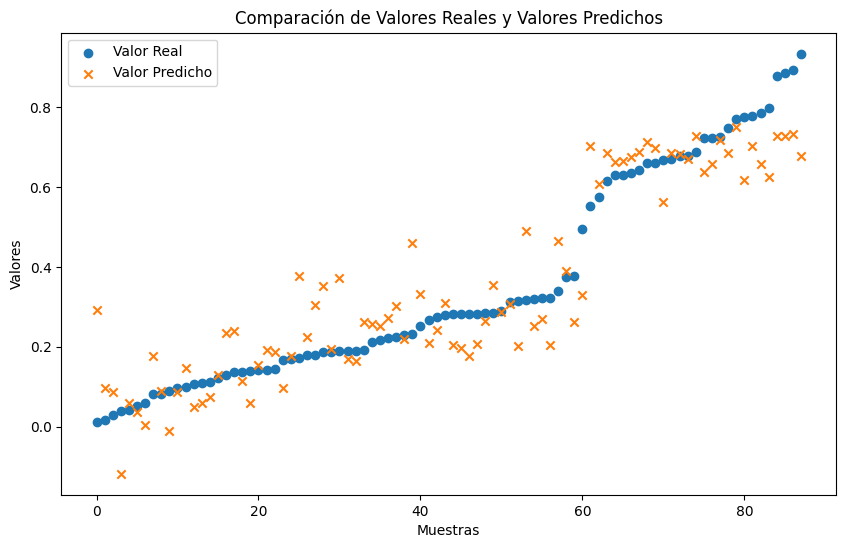

In [54]:
import matplotlib.pyplot as plt

# Crear un DataFrame con los valores originales y predichos
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Predicho': y_pred_test_lr})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df = comparison_df.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df)), comparison_df['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df)), comparison_df['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()


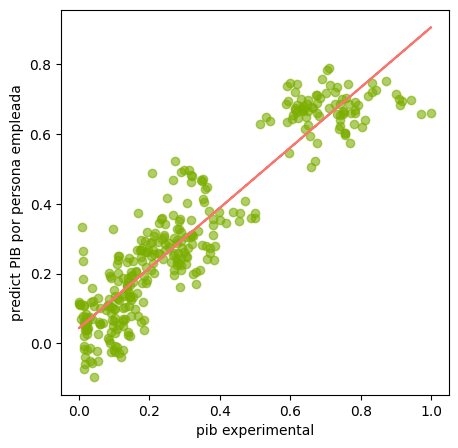

In [55]:
import numpy as np
plt.figure(figsize=(5,5))
plt.scatter(x= y_train, y=y_pred_train_lr,c = "#7CAE00",  alpha = 0.6)

z = np.polyfit(y_train, y_pred_train_lr,1)
p = np.poly1d(z)

plt.ylabel('predict PIB por persona empleada')
plt.xlabel('pib experimental')
plt.plot(y_train, p(y_train), "#F8766D")

In [56]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_test_lr)
r2 = r2_score(y_test, y_pred_test_lr)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")


Error Cuadrático Medio (MSE): 0.009353712380888704
Coeficiente de Determinación (R²): 0.8626231030026683


merged_global.info()


In [57]:
##randomforest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 2, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=42)

In [58]:
y_pred_test_rf = rf.predict(X_test)
y_pred_train_rf = rf.predict(X_train)

In [59]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_test_rf)
r2 = r2_score(y_test, y_pred_test_rf)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de Determinación (R²): {r2}")


Error Cuadrático Medio (MSE): 0.00623692913342146
Coeficiente de Determinación (R²): 0.9083989397736548


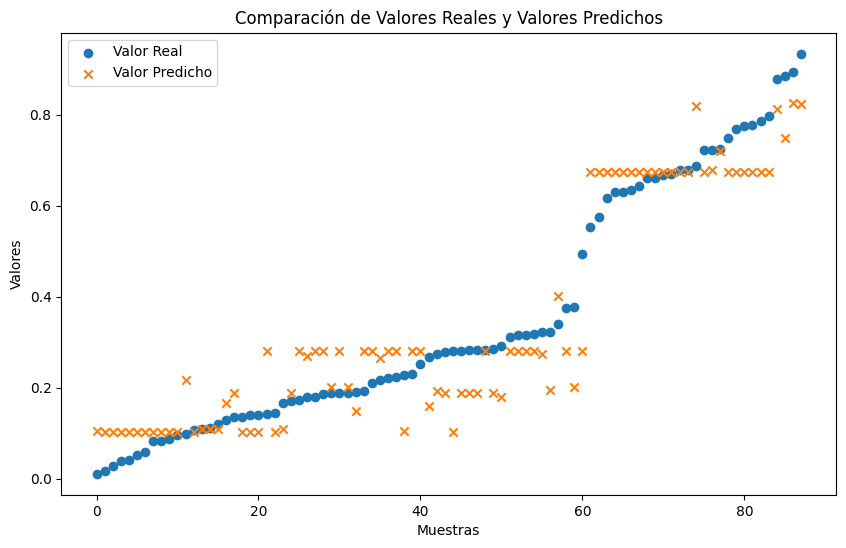

In [62]:
import matplotlib.pyplot as plt

# Crear un DataFrame con los valores originales y predichos
comparison_df = pd.DataFrame({'Valor Real': y_test, 'Valor Predicho': y_pred_test_rf})

# Ordenar el DataFrame por 'Valor Real' para una mejor visualización
comparison_df = comparison_df.sort_values(by='Valor Real')

# Crear un gráfico de dispersión para visualizar la comparación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df)), comparison_df['Valor Real'], label='Valor Real', marker='o')
plt.scatter(range(len(comparison_df)), comparison_df['Valor Predicho'], label='Valor Predicho', marker='x')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Valores Predichos')
plt.legend()
plt.show()


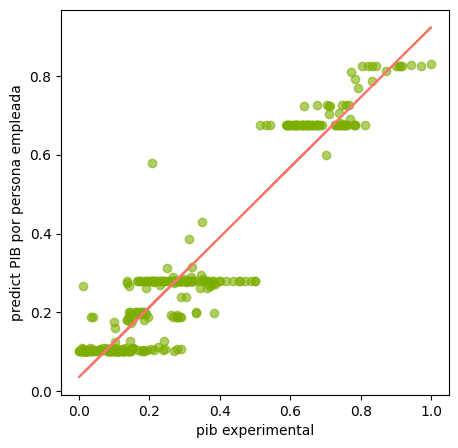

In [61]:
import numpy as np
plt.figure(figsize=(5,5))
plt.scatter(x= y_train, y=y_pred_train_rf,c = "#7CAE00",  alpha = 0.6)

z = np.polyfit(y_train, y_pred_train_rf,1)
p = np.poly1d(z)

plt.ylabel('predict PIB por persona empleada')
plt.xlabel('pib experimental')
plt.plot(y_train, p(y_train), "#F8766D")

In [63]:
##### Crear diccionario de agrupación por cercanía geográfica
geographical_groups = {
    "América del Norte": ["USA", "CAN"],
    "América del Sur": ["ARG", "BHS", "BRB", "BOL", "BRA", "COL", "CRI", "CUB", "CHL", "ECU", "SLV", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "PAN", "PRY", "PER", "SUR", "TTO", "URY", "VEN"],
    "Europa": ["FRA", "GBR", "NLD"],
    "Otras Regiones": ["DOM"]
}

# Crear una columna "Grupo Geográfico"
merged_df['Region'] = merged_df['Country'].map({country: group for group, countries in geographical_groups.items() for country in countries})

# Crear un diccionario de subregiones de América Latina
subregiones_latinoamerica = {
    "América del Norte": ["USA", "CAN"],
    "Europa": ["FRA", "GBR", "NLD"],
    "Otras Regiones": ["DOM"],
    "LA-Cono Sur": ["ARG", "CHL", "URY", "PAR"],
    "LA-Región Andina": ["COL", "ECU", "PER", "BOL"],
    "LA-Región Amazónica": ["BRA", "VEN", "GUY"],
    "LA-Región del Caribe": ["VEN", "COL", "GUY"]
}

# Crear una columna "Subregión de América Latina"
merged_df['Subregion'] = merged_df['Country'].map({country: subregion for subregion, countries in subregiones_latinoamerica.items() for country in countries})

# Reorganizar las columnas para poner las nuevas al principio
merged_df = merged_df[['Country', 'Region', 'Subregion'] + [col for col in merged_df.columns if col not in ['Country', 'Region', 'Subregion']]]


In [64]:
merged_df.drop

<bound method DataFrame.drop of     Country             Region          Subregion  Year  CRP_CC.EST  \
0       ARG    América del Sur        LA-Cono Sur  2021    0.282113   
1       ARG    América del Sur        LA-Cono Sur  2020    0.353990   
2       ARG    América del Sur        LA-Cono Sur  2019    0.369795   
3       ARG    América del Sur        LA-Cono Sur  2018    0.372095   
4       ARG    América del Sur        LA-Cono Sur  2017    0.313666   
..      ...                ...                ...   ...         ...   
432     USA  América del Norte  América del Norte  2003    0.873487   
433     USA  América del Norte  América del Norte  2002    0.920509   
434     USA  América del Norte  América del Norte  2000    0.845432   
435     USA  América del Norte  América del Norte  1998    0.830361   
436     USA  América del Norte  América del Norte  1996    0.836379   

     CRP_GE.EST  CRP_PV.EST  CRP_RL.EST  CRP_RQ.EST  CRP_VA.EST  ...  \
0      0.227405    0.574767    0.238664    

In [71]:
"""
import pandas as pd
import pandas as pd

# Excluir la columna 'Year' para el cálculo del promedio por país
promedio_por_pais = merged_df.drop(columns=['Year']).groupby('Country').mean().reset_index() 

# Calcular el promedio por región
promedio_por_region = merged_df.drop(columns=['Year']).groupby('Region').mean().reset_index()

# Calcular el promedio por subregión
promedio_por_subregion = merged_df.drop(columns=['Year']).groupby('Subregion').mean().reset_index()

# Calcular el promedio general excluyendo la columna 'Year'
promedio_general = merged_df.drop(columns=['Year']).mean().to_frame('Promedio General').T

# Filtrar los datos para el país Colombia (COL)
datos_colombia = merged_df.drop[merged_df['Country'] == 'COL']

# Calcular el promedio para Colombia, excluyendo la columna 'Year'
promedio_colombia = datos_colombia.drop(columns=['Year']).mean().to_frame('Promedio Colombia').T

# Visualizar el DataFrame con el promedio para Colombia
print(promedio_colombia)

# Visualizar el DataFrame con los promedios por país
print(promedio_por_pais)

# Visualizar el DataFrame con los promedios por región
print(promedio_por_region)

# Visualizar el DataFrame con los promedios por subregión
print(promedio_por_subregion)

########
########




SyntaxError: incomplete input (3608168810.py, line 1)

In [72]:
"""
# Visualizar el DataFrame con el promedio para Colombia
#print(promedio_colombia)

# Visualizar el DataFrame con los promedios por país
#print(promedio_por_pais)

# Visualizar el DataFrame con los promedios por región
#print(promedio_por_region)

# Visualizar el DataFrame con los promedios por subregión
print(promedio_por_subregion)


SyntaxError: incomplete input (3597018201.py, line 1)

In [73]:
"""
import matplotlib.pyplot as plt
# Crear un gráfico de líneas
plt.figure(figsize=(10, 6))

# Dibujar el gráfico de líneas para el promedio general
plt.plot(promedio_general.columns, promedio_general.iloc[0], label='Promedio General', linestyle='-', marker='o', color='gray')

# Dibujar el gráfico de líneas para el promedio de Colombia en rojo oscuro
plt.plot(promedio_colombia.columns, promedio_colombia.iloc[0], label='Promedio Colombia', linestyle='-', marker='o', color='darkred')

# Configuraciones de estilo y etiquetas
plt.xticks(rotation=45)
plt.title('Comparación de Promedio General y Promedio Colombia')
plt.xlabel('Indicador')
plt.ylabel('Promedio')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

NameError: name 'promedio_general' is not defined

<Figure size 1000x600 with 0 Axes>

In [61]:
print(promedio_colombia)

NameError: name 'promedio_colombia' is not defined

In [60]:
"""merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                437 non-null    object 
 1   Region                 437 non-null    object 
 2   Subregion              322 non-null    object 
 3   Year                   437 non-null    int32  
 4   CRP_CC.EST             437 non-null    float64
 5   CRP_GE.EST             437 non-null    float64
 6   CRP_PV.EST             437 non-null    float64
 7   CRP_RL.EST             437 non-null    float64
 8   CRP_RQ.EST             437 non-null    float64
 9   CRP_VA.EST             437 non-null    float64
 10  ODS_NV.AGR.EMPL.KD     437 non-null    float64
 11  ODS_SL.AGR.EMPL.ZS     437 non-null    float64
 12  ODS_SL.AGR.EMPL.FE.ZS  437 non-null    float64
 13  ODS_SL.AGR.EMPL.MA.ZS  437 non-null    float64
 14  ODS_SL.IND.EMPL.ZS     437 non-null    float64
 15  ODS_SL

In [59]:
"""# Importar la biblioteca pandas
import pandas as pd

# Calcular estadísticas descriptivas
descriptive_stats = merged_df.describe()


In [58]:
"""descriptive_stats

NameError: name 'descriptive_stats' is not defined

In [ ]:
"""# Exportar las estadísticas descriptivas a un archivo Excel
descriptive_stats.to_excel('analisis_descriptivo.xlsx', sheet_name='Estadisticas')


In [ ]:
"""print(result_df2)

In [ ]:
"""merged_df.info()

In [ ]:
"""# Reemplaza 'nombre_archivo' con el nombre que deseas para tu archivo Excel
nombre_archivo1 = "merged_df.xlsx"
ruta_archivo1 = r"D:\DANI LAPTOP\Documentos\Setting\OneDrive - Ucompensar\esp files\Segundo semestre\Seminario de grado big data\Extraccion\\" + nombre_archivo1

# Guarda el DataFrame resultante como un archivo Excel
merged_df.to_excel(ruta_archivo1, index=False)


from ydata_profiling import ProfileReport

# Supongamos que merged_df es tu DataFrame resultante

# Crear un informe de análisis univariado y bivariado
prof2 = ProfileReport(merged_df)

# Guardar el informe en un archivo HTML
prof2.to_file(output_file='Analisis_Univariado2.html')



In [ ]:
"""import ydata_profiling

from pandas_profiling import ProfileReport

# Lista de países
paises = [

    ["FRA", "GBR"]
]

# Crear un informe para cada país en la lista
for grupo_paises in paises:
    for pais in grupo_paises:
        # Filtrar merged_df por el país actual y obtener una copia
        merged_df_pais = merged_df[merged_df['Country'] == pais].copy()

        # Generar el informe de perfil para el país actual
        profile = ProfileReport(merged_df_pais)

        # Guardar el informe en un archivo HTML con el nombre del país
        output_file = f'Analisis_Univariado_{pais}.html'
        profile.to_file(output_file)

        print(f'Informe de {pais} guardado en {output_file}')


In [ ]:
"""# Definir un nombre de archivo para guardar los DataFrames en Excel
nombre_archivo = "promedios.xlsx"

# Crear un escritor de Excel (puedes personalizar el formato si lo deseas)
with pd.ExcelWriter(nombre_archivo) as writer:
    # Guardar el DataFrame promedio_colombia en una hoja llamada "Promedio Colombia"
    promedio_colombia.to_excel(writer, sheet_name='Promedio Colombia', index=False)

    # Guardar el DataFrame promedio_por_pais en una hoja llamada "Promedio por País"
    promedio_por_pais.to_excel(writer, sheet_name='Promedio por País', index=False)

    # Guardar el DataFrame promedio_por_region en una hoja llamada "Promedio por Región"
    promedio_por_region.to_excel(writer, sheet_name='Promedio por Región', index=False)

    # Guardar el DataFrame promedio_por_subregion en una hoja llamada "Promedio por Subregión"
    promedio_por_subregion.to_excel(writer, sheet_name='Promedio por Subregión', index=False)

print(f"Los DataFrames han sido exportados a '{nombre_archivo}'.")
